#**Transfer Learning**

**Reference**: Deep Learning for Data Science (BCS, FICT)




**Why do we need Transfer Learning?**
* Saving effort to train a model from scratch
* Transfer learning reduces overfitting and improves the generalization performance (especially when the training set for the targeted task is small)


In practice, it is common to use a **CNN architectures** such that ResNet, MNASNet, ResNeXt, EfficientNet, etc. to build a model. The effectiveness of these network architectures has been well attested for a wide range of applications.  The [`torchvision.models`](https://pytorch.org/vision/stable/models.html) package contains these different network models that have been pre-trained on ImageNet.

In general, there are two ways to perform transfer learning:

1. **Finetuning the entire network**: Instead of random initialization,  initialize the network with the pretrained network.

2. **Fixed feature extractor**: Freeze the weights for all of the layers of the network except for the final fully connected (fc) layer. Replace the last fc layer so that the output size is the same as the number of classes for the new task. The new layer is initialized with random weights and only this layer is trained.


**Objective:**

To train a pretrain model by:
1. Training from scratch (without pretrained weights)
2. Finetuning the entire pretrained model
3. Finetuning the upper (last few) layers of the pretrained model
4. Finetuning only the fc layers (fixed feature extractor)

**Remember** to enable the GPU for this notebook before we start:

1. by setting `Edit` >
`Notebook settings` > `Hardware accelerator` to `GPU` or,

2. by setting `Runtime` > `Change Runtime Type`> `Hardward Accelerator` to `GPU`.

Mount google drive onto virtual machine

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/MyDrive/PDL_2023"

/content/gdrive/MyDrive/PDL_2023


In [3]:
!mkdir P07
%cd ./P07

mkdir: cannot create directory ‘P07’: File exists
/content/gdrive/MyDrive/PDL_2023/P07


Download the helper function to load data

In [4]:
# Download the cifar10 function from google drive
!gdown --fuzzy https://drive.google.com/file/d/1OgEoKomios7ZLSQGlG4NJHrH_mIGYK98/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1OgEoKomios7ZLSQGlG4NJHrH_mIGYK98
From (redirected): https://drive.google.com/uc?id=1OgEoKomios7ZLSQGlG4NJHrH_mIGYK98&confirm=t&uuid=ce4a6e40-40b5-4b37-b9f1-d2086b125a49
To: /content/gdrive/MyDrive/PDL_2023/P07/cifar10.py
100% 1.48k/1.48k [00:00<00:00, 7.32MB/s]


Load required libraries

In [5]:
import numpy as np
import torchvision.models as models

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchsummary import summary

from cifar10 import CIFAR10

---
## Helper Functions

Define the train function

In [6]:
loss_iter = 1

def train(net, num_epochs, lr=0.1, momentum=0.9, verbose=True):

    history = []

    loss_iterations = int(np.ceil(len(trainloader)/loss_iter))

    # transfer model to GPU
    if torch.cuda.is_available():
        net = net.cuda()

    # set the optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    # set to training mode
    net.train()

    # train the network
    for e in range(num_epochs):

        running_loss = 0.0
        running_count = 0.0

        for i, (inputs, labels) in enumerate(trainloader):

            # Clear all the gradient to 0
            optimizer.zero_grad()

            # transfer data to GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # forward propagation to get h
            outs = net(inputs)

            # compute loss
            loss = F.cross_entropy(outs, labels)

            # backpropagation to get dw
            loss.backward()

            # update w
            optimizer.step()

            # get the loss
            running_loss += loss.item()
            running_count += 1

             # display the averaged loss value
            if i % loss_iterations == loss_iterations-1 or i == len(trainloader) - 1:
                train_loss = running_loss / running_count
                running_loss = 0.
                running_count = 0.
                if verbose:
                    print(f'[Epoch {e+1:2d}/{num_epochs:d} Iter {i+1:5d}/{len(trainloader)}]: train_loss = {train_loss:.4f}')

                history.append(train_loss)

    return history

Define the evaluate function

In [7]:
def evaluate(net):
    # set to evaluation mode
    net.eval()

    # running_correct
    running_corrects = 0

    for inputs, targets in testloader:

        # transfer to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()

        # perform prediction (no need to compute gradient)
        with torch.no_grad():
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            running_corrects += (targets == predicted).double().sum()

    print('Accuracy = {:.2f}%'.format(100*running_corrects/len(testloader.dataset)))

---
## 1 Load CIFAR10 dataset

Load the dataset with the following transformation pipeline.

**Noted:**

We are using a sub-sample of CIFAR10 where we use a sub-sample of 1000 training and testing samples.

The sample size is **small** and hence is expected to face **overfitting** issue. Using a pretrained model is helpful to alleviate the problem.

In [8]:
# transform the model
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset = CIFAR10(train=True, download=True, transform=transform, num_samples=1000)
testset  = CIFAR10(train=False, download=True, transform=transform, num_samples=1000)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


---

## 2 ResNet50 model

In this practical, we will use  a pre-trained [ResNet50](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#resnet50) for the 4 training methods.

**Noted:**

 * The original ResNet50 was designed to classify ImageNet's 1000 image categories

* Since we will be using CIFAR10 (10 classes), we need to customize the network by replacing its classifier layer (last fc layer)  later




### 2.1 Loading the pretrained models

`TorchVision` provides two pretrained models for ResNet50 together their reported accurcies on ImageNet-1K with single crops:

|**weight**|**Acc@1**|**Acc@5**|**Params**|
|:---:|:---:|:---:|:---:|
|ResNet50_Weights.IMAGENET1K_V1|76.13|92.862|25.6MB|
|ResNet50_Weights.IMAGENET1K_V2|80.858|95.434|25.6MB|

where IMAGENET1K_V2 improves upon IMAGENET1K_V1 by using a new [training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)

We can specify the pretrained model through:
1. predefined constant argument, or
2. string argument


In [9]:
from torchvision.models import resnet50, ResNet50_Weights

In [10]:
# load pretrained resnet18 model with predefined constant argument
net = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.7MB/s]


In [11]:
# load pretrained resnet18 model with string argument
net = resnet50(weights="IMAGENET1K_V2")

### 2.2 Inferencing with the pretrained model

Some pretrained model needs specific preprocessing steps (e.g., resize into a specific resolution / rescale the values, etc.)

The preprocessing steps vary depending on how the model was trained. The necessary information for inference transforms are provided on the weight documentation.

To simplify inference, `TorchVision` bundle  `transform` utility into `ResNet.Weights` (do not require transform pipelibe)

Let's try a simple example of "tabby cat".

In [12]:
# Download the example image from drive
!gdown --fuzzy https://drive.google.com/file/d/1Ury2q1BmuwHO1HufuwmVu3_4zh72UoYT/view?usp=drive_link

Downloading...
From: https://drive.google.com/uc?id=1Ury2q1BmuwHO1HufuwmVu3_4zh72UoYT
To: /content/gdrive/MyDrive/PDL_2023/P07/Tabby_cat.jpg
100% 17.8k/17.8k [00:00<00:00, 45.5MB/s]


In [13]:
# load the preprocess function for image transformation
weight = ResNet50_Weights.IMAGENET1K_V2
preprocess = weight.transforms()

In [14]:
# read image
from torchvision.io import read_image
img = read_image('Tabby_cat.jpg')
print('Shape of x (before preprocessing)', img.shape)

# preprocess image will return shape (C,H,W)
x = preprocess(img)
print('Shape of x after preprocessing:', x.shape)

# we have to create the batch dimension (1, C, H, W)
x = x.unsqueeze(0)

print('Shape of x after unsqueezing:', x.shape)

Shape of x (before preprocessing) torch.Size([3, 162, 288])
Shape of x after preprocessing: torch.Size([3, 224, 224])
Shape of x after unsqueezing: torch.Size([1, 3, 224, 224])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Now we can perform inference with the pretrained model.

 The classes of the pretrained model can be found at `weights.meta['categories']`.

In [15]:
net.eval()
with torch.no_grad():
        score = net(x)
        predicted = score.argmax(axis=1)[0]

print('Predicted label =', weight.meta['categories'][predicted])

Predicted label = tabby



### 2.3 Customizing ResNet50

Now, let's replace the last layer with a new classifier layer so that it is adaptable to  Cifar10's 10 classes.

First, let's check the architecture of ResNet50 and how it is implemented in PyTorch:

In [16]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Check at higher level: displaying only the children of network (named blocks):


In [17]:
# print the children of network
for name, _ in net.named_children():
       print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


Here are some observations:
* `conv1`, `bn1`, `relu` and `maxpool` are the *stem* network
* There are 4 *blocks* in the network, namely `layer1`, `layer2`, `layer3` and `layer4`.
* Each of the block contains two convolutional layers.
* The second last layer (`avgpool`) performs *global average pooling* to average out the spatial dimensions.
* The last layer (`fc`) is a linear layer that functions as a classifier. (This is the layer that we want to replace to fit our model)

Now, lets customize the network by replacing the `fc` layer with our own classifier layer.


In [18]:
def build_network(weights=None):
        net = resnet50(weights=weights)
        in_c = net.fc.in_features
        net.fc = nn.Linear(in_c, 10)
        return net

Let's visualize the customized network again.

You should find  the last layer of the network (`fc`) now has 10 instead of 1000 neurons.

In [19]:
print(build_network())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

---
## Model 1: Training from scratch

To train the ResNet50 from scratch, the weights are initialized randomly as standard training.

Let's build the network **without** loading the pretrained model. To do this, we shall set `weights=None`.

In [20]:
# Load the an empty model (without pretrained weights)
net1 = build_network(weights=None)

Train the model and save the training loss history into `history1`.

In [21]:
history1 = train(net1, num_epochs=30, lr=0.01, momentum=0.8)

[Epoch  1/30 Iter    32/32]: train_loss = 4.0904
[Epoch  2/30 Iter    32/32]: train_loss = 2.8636
[Epoch  3/30 Iter    32/32]: train_loss = 2.5567
[Epoch  4/30 Iter    32/32]: train_loss = 2.3508
[Epoch  5/30 Iter    32/32]: train_loss = 2.2909
[Epoch  6/30 Iter    32/32]: train_loss = 2.0776
[Epoch  7/30 Iter    32/32]: train_loss = 2.0285
[Epoch  8/30 Iter    32/32]: train_loss = 2.0023
[Epoch  9/30 Iter    32/32]: train_loss = 1.9648
[Epoch 10/30 Iter    32/32]: train_loss = 1.8828
[Epoch 11/30 Iter    32/32]: train_loss = 1.8560
[Epoch 12/30 Iter    32/32]: train_loss = 1.8321
[Epoch 13/30 Iter    32/32]: train_loss = 1.8239
[Epoch 14/30 Iter    32/32]: train_loss = 1.7725
[Epoch 15/30 Iter    32/32]: train_loss = 1.9025
[Epoch 16/30 Iter    32/32]: train_loss = 1.7298
[Epoch 17/30 Iter    32/32]: train_loss = 1.7412
[Epoch 18/30 Iter    32/32]: train_loss = 1.7106
[Epoch 19/30 Iter    32/32]: train_loss = 1.6115
[Epoch 20/30 Iter    32/32]: train_loss = 1.6704
[Epoch 21/30 Iter   

Evaluate the model

In [22]:
evaluate(net1)

Accuracy = 33.20%


---
## Model 2: Finetuning the entire model

To finetune the ResNet50,we will initialize the network with the pretrained weights.

Let's load ResNet50 with the pretrained weights and use it to initialize the network.  To do this, we set `weights='IMAGENET1K_V2'`.

**Noted:**

The training will update ALL the parameters in every layers of the network.

**For Windows system:** (local GPU)

The pretrained model will be saved to the following directory: `C:\Users\<user name>\.cache\torch\checkpoints`. A PyTorch model has an extension of `.pt` or `.pth`.

In [23]:
# Load the pretrained model
net2 = build_network(weights='IMAGENET1K_V2')

By default, all the layers are set to `requires_grad=True`

In [24]:
# display the requires_grad for all layers
for name, param in net2.named_parameters():
       print(name, ':', param.requires_grad)

conv1.weight : True
bn1.weight : True
bn1.bias : True
layer1.0.conv1.weight : True
layer1.0.bn1.weight : True
layer1.0.bn1.bias : True
layer1.0.conv2.weight : True
layer1.0.bn2.weight : True
layer1.0.bn2.bias : True
layer1.0.conv3.weight : True
layer1.0.bn3.weight : True
layer1.0.bn3.bias : True
layer1.0.downsample.0.weight : True
layer1.0.downsample.1.weight : True
layer1.0.downsample.1.bias : True
layer1.1.conv1.weight : True
layer1.1.bn1.weight : True
layer1.1.bn1.bias : True
layer1.1.conv2.weight : True
layer1.1.bn2.weight : True
layer1.1.bn2.bias : True
layer1.1.conv3.weight : True
layer1.1.bn3.weight : True
layer1.1.bn3.bias : True
layer1.2.conv1.weight : True
layer1.2.bn1.weight : True
layer1.2.bn1.bias : True
layer1.2.conv2.weight : True
layer1.2.bn2.weight : True
layer1.2.bn2.bias : True
layer1.2.conv3.weight : True
layer1.2.bn3.weight : True
layer1.2.bn3.bias : True
layer2.0.conv1.weight : True
layer2.0.bn1.weight : True
layer2.0.bn1.bias : True
layer2.0.conv2.weight : True
l

Train the model and save into `history2`.

In [25]:
history2 = train(net2, num_epochs=30, lr=0.01, momentum=0.8)

[Epoch  1/30 Iter    32/32]: train_loss = 2.0154
[Epoch  2/30 Iter    32/32]: train_loss = 1.0903
[Epoch  3/30 Iter    32/32]: train_loss = 0.6149
[Epoch  4/30 Iter    32/32]: train_loss = 0.4009
[Epoch  5/30 Iter    32/32]: train_loss = 0.2087
[Epoch  6/30 Iter    32/32]: train_loss = 0.1762
[Epoch  7/30 Iter    32/32]: train_loss = 0.1160
[Epoch  8/30 Iter    32/32]: train_loss = 0.1356
[Epoch  9/30 Iter    32/32]: train_loss = 0.1048
[Epoch 10/30 Iter    32/32]: train_loss = 0.0570
[Epoch 11/30 Iter    32/32]: train_loss = 0.0592
[Epoch 12/30 Iter    32/32]: train_loss = 0.0606
[Epoch 13/30 Iter    32/32]: train_loss = 0.0585
[Epoch 14/30 Iter    32/32]: train_loss = 0.0522
[Epoch 15/30 Iter    32/32]: train_loss = 0.0351
[Epoch 16/30 Iter    32/32]: train_loss = 0.0374
[Epoch 17/30 Iter    32/32]: train_loss = 0.0512
[Epoch 18/30 Iter    32/32]: train_loss = 0.0302
[Epoch 19/30 Iter    32/32]: train_loss = 0.0278
[Epoch 20/30 Iter    32/32]: train_loss = 0.0224
[Epoch 21/30 Iter   

Evaluate the network

In [26]:
evaluate(net2)

Accuracy = 83.00%


---
## Model 3: Finetuning the fc layers (fixed feature extractor)

When the dataset is too small, fine-tuning the model may still incur overfitting.

In this case, you may want to try to use the pretrained network as a fixed feature extractor where we train only the  classifier (fc layer)

In [27]:
# Load the pretrained model
net3 = build_network(weights='IMAGENET1K_V2')

To freeze the feature extractor, we have to set `requires_grad=False` for all parameters in  `resnet.parameters()` except for the new  `fc` layer

In [28]:
# set requires grad to FALSE for all parameters except the fc layer
parameters = list(net3.parameters())
for param in parameters[:-2]:
       param.requires_grad = False

In [29]:
# display the requires_grad for all layers to confirm that the gradients have been set correctly
for name, param in net3.named_parameters():
        print(name, ':', param.requires_grad)

conv1.weight : False
bn1.weight : False
bn1.bias : False
layer1.0.conv1.weight : False
layer1.0.bn1.weight : False
layer1.0.bn1.bias : False
layer1.0.conv2.weight : False
layer1.0.bn2.weight : False
layer1.0.bn2.bias : False
layer1.0.conv3.weight : False
layer1.0.bn3.weight : False
layer1.0.bn3.bias : False
layer1.0.downsample.0.weight : False
layer1.0.downsample.1.weight : False
layer1.0.downsample.1.bias : False
layer1.1.conv1.weight : False
layer1.1.bn1.weight : False
layer1.1.bn1.bias : False
layer1.1.conv2.weight : False
layer1.1.bn2.weight : False
layer1.1.bn2.bias : False
layer1.1.conv3.weight : False
layer1.1.bn3.weight : False
layer1.1.bn3.bias : False
layer1.2.conv1.weight : False
layer1.2.bn1.weight : False
layer1.2.bn1.bias : False
layer1.2.conv2.weight : False
layer1.2.bn2.weight : False
layer1.2.bn2.bias : False
layer1.2.conv3.weight : False
layer1.2.bn3.weight : False
layer1.2.bn3.bias : False
layer2.0.conv1.weight : False
layer2.0.bn1.weight : False
layer2.0.bn1.bias : 

Train the model and save into `history3`.

In [30]:
history3 = train(net3, num_epochs=30, lr=0.01, momentum=0.8)

[Epoch  1/30 Iter    32/32]: train_loss = 2.0597
[Epoch  2/30 Iter    32/32]: train_loss = 1.5939
[Epoch  3/30 Iter    32/32]: train_loss = 1.3564
[Epoch  4/30 Iter    32/32]: train_loss = 1.2485
[Epoch  5/30 Iter    32/32]: train_loss = 1.1775
[Epoch  6/30 Iter    32/32]: train_loss = 1.0834
[Epoch  7/30 Iter    32/32]: train_loss = 1.0292
[Epoch  8/30 Iter    32/32]: train_loss = 0.9773
[Epoch  9/30 Iter    32/32]: train_loss = 0.9618
[Epoch 10/30 Iter    32/32]: train_loss = 0.9113
[Epoch 11/30 Iter    32/32]: train_loss = 0.8969
[Epoch 12/30 Iter    32/32]: train_loss = 0.8716
[Epoch 13/30 Iter    32/32]: train_loss = 0.8521
[Epoch 14/30 Iter    32/32]: train_loss = 0.8350
[Epoch 15/30 Iter    32/32]: train_loss = 0.8326
[Epoch 16/30 Iter    32/32]: train_loss = 0.8062
[Epoch 17/30 Iter    32/32]: train_loss = 0.7812
[Epoch 18/30 Iter    32/32]: train_loss = 0.7922
[Epoch 19/30 Iter    32/32]: train_loss = 0.7602
[Epoch 20/30 Iter    32/32]: train_loss = 0.7527
[Epoch 21/30 Iter   

Evaluate the model

In [31]:
evaluate(net3)

Accuracy = 70.00%


---
## Model 4: Finetune the top (last few) layers

Sometime, you may want to finetune the feature extractor for higher-level features.

To do this, we can tune the top few layers of the network (layers in the block `layer 4` and `fc` layer)


In [32]:
# Load the pretrained model
net4 = build_network(weights='IMAGENET1K_V2')

Then, we freeze all tha layers except for `layer4` and `fc` layers

In [33]:
for name, param in net4.named_parameters():
       if not any(name.startswith(ext) for ext in ['layer4', 'fc']):
           param.requires_grad = False

In [34]:
for name, param in net4.named_parameters():
       print(name, ':', param.requires_grad)

conv1.weight : False
bn1.weight : False
bn1.bias : False
layer1.0.conv1.weight : False
layer1.0.bn1.weight : False
layer1.0.bn1.bias : False
layer1.0.conv2.weight : False
layer1.0.bn2.weight : False
layer1.0.bn2.bias : False
layer1.0.conv3.weight : False
layer1.0.bn3.weight : False
layer1.0.bn3.bias : False
layer1.0.downsample.0.weight : False
layer1.0.downsample.1.weight : False
layer1.0.downsample.1.bias : False
layer1.1.conv1.weight : False
layer1.1.bn1.weight : False
layer1.1.bn1.bias : False
layer1.1.conv2.weight : False
layer1.1.bn2.weight : False
layer1.1.bn2.bias : False
layer1.1.conv3.weight : False
layer1.1.bn3.weight : False
layer1.1.bn3.bias : False
layer1.2.conv1.weight : False
layer1.2.bn1.weight : False
layer1.2.bn1.bias : False
layer1.2.conv2.weight : False
layer1.2.bn2.weight : False
layer1.2.bn2.bias : False
layer1.2.conv3.weight : False
layer1.2.bn3.weight : False
layer1.2.bn3.bias : False
layer2.0.conv1.weight : False
layer2.0.bn1.weight : False
layer2.0.bn1.bias : 

Train the model and save into `history4`.

In [35]:
history4 = train(net4, num_epochs=30, lr=0.01, momentum=0.8)

[Epoch  1/30 Iter    32/32]: train_loss = 1.9984
[Epoch  2/30 Iter    32/32]: train_loss = 1.2703
[Epoch  3/30 Iter    32/32]: train_loss = 0.9334
[Epoch  4/30 Iter    32/32]: train_loss = 0.7327
[Epoch  5/30 Iter    32/32]: train_loss = 0.6493
[Epoch  6/30 Iter    32/32]: train_loss = 0.5215
[Epoch  7/30 Iter    32/32]: train_loss = 0.4646
[Epoch  8/30 Iter    32/32]: train_loss = 0.3755
[Epoch  9/30 Iter    32/32]: train_loss = 0.3027
[Epoch 10/30 Iter    32/32]: train_loss = 0.2641
[Epoch 11/30 Iter    32/32]: train_loss = 0.2150
[Epoch 12/30 Iter    32/32]: train_loss = 0.1874
[Epoch 13/30 Iter    32/32]: train_loss = 0.1496
[Epoch 14/30 Iter    32/32]: train_loss = 0.1750
[Epoch 15/30 Iter    32/32]: train_loss = 0.1755
[Epoch 16/30 Iter    32/32]: train_loss = 0.1309
[Epoch 17/30 Iter    32/32]: train_loss = 0.1187
[Epoch 18/30 Iter    32/32]: train_loss = 0.0920
[Epoch 19/30 Iter    32/32]: train_loss = 0.0836
[Epoch 20/30 Iter    32/32]: train_loss = 0.0660
[Epoch 21/30 Iter   

Evaluate the model

In [36]:
evaluate(net4)

Accuracy = 78.00%


## 3 Compare the Training Loss

Lastly, let's plot the training loss history for each of the training schemes for simple comparison:

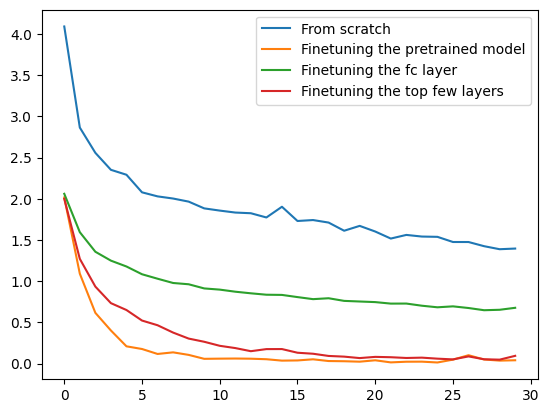

In [37]:
import matplotlib.pyplot as plt

plt.plot(history1, label='From scratch')
plt.plot(history2, label='Finetuning the pretrained model')
plt.plot(history3, label='Finetuning the fc layer')
plt.plot(history4, label='Finetuning the top few layers')
plt.legend()
plt.show()

---
#<center>- End of P07 -
---